In [135]:
import pandas as pd           
import praw                   
import re                     
import datetime as dt
import seaborn as sns
import requests
import json
import sys
import time
## acknowledgements
'''
https://stackoverflow.com/questions/48358837/pulling-reddit-comments-using-python-praw-and-creating-a-dataframe-with-the-resu
https://www.reddit.com/r/redditdev/comments/2e2q2l/praw_downvote_count_always_zero/
https://towardsdatascience.com/an-easy-tutorial-about-sentiment-analysis-with-deep-learning-and-keras-2bf52b9cba91

For navigating pushshift: https://github.com/Watchful1/Sketchpad/blob/master/postDownloader.py
'''

'\nhttps://stackoverflow.com/questions/48358837/pulling-reddit-comments-using-python-praw-and-creating-a-dataframe-with-the-resu\nhttps://www.reddit.com/r/redditdev/comments/2e2q2l/praw_downvote_count_always_zero/\nhttps://towardsdatascience.com/an-easy-tutorial-about-sentiment-analysis-with-deep-learning-and-keras-2bf52b9cba91\n'

In [4]:
with open("API.env") as file:
    exec(file.read())

reddit = praw.Reddit(
  client_id = client_id,
  client_secret = client_secret,
  user_agent = user_agent
)

Version 7.0.0 of praw is outdated. Version 7.2.0 was released Wednesday February 24, 2021.


In [255]:
'''
Some helper functions for the reddit API.
'''

def extract_num_rewards(awardings_data):
    return sum( x["count"] for x in awardings_data)

def extract_data(submission, comments = True):
    postlist = []

    # extracts top level comments
    if comments:
        submission.comments.replace_more(limit=0)
        for comment in submission.comments: 
            post = {} # put this here
            post['author'] = comment.author
            post['body'] = comment.body
            post['awards'] = comment.all_awardings
            post['score'] = comment.score
            post['parent_id'] = comment.parent_id
            post['id'] = comment.id

            postlist.append(post)

    content = {
    "title" : submission.title,
    "self" : submission.is_self,
    "text" : submission.selftext,
    "comments" : postlist,
    "author" : submission.author,
    "name" : submission.name,
    "upvote_ratio" : submission.upvote_ratio,
    "ups" : submission.score, #this is the same as submission.ups,
    "downs" : None,
    "awarders" : submission.awarders, 
    "awards" : submission.all_awardings,
    "total_awards" : None,
    "url" : submission.url # Only relevent if not a self post
    }
    
    content["total_awards"] = extract_num_rewards(content["awards"])
    content["downs"] = (1 - content["upvote_ratio"]) * content["ups"] / content["upvote_ratio"]
    return content

In [44]:
'''
Sample num_samples random submissions, and get the top num_samples submissions, and put them into dataframes.
'''

def random_sample(num_samples, subreddit):
    sample = []
    for i in range(num_samples):
        submission = reddit.subreddit(subreddit).random() 
        sample.append(extract_data(submission))
    return(pd.DataFrame(sample))

def sample(source):
    submissions = []
    for submission in source:
        submissions.append(extract_data(submission))
    print(f"Got {len(submissions)} submissions. (This can be less than num_samples.)")
    return(pd.DataFrame(submissions))

def top_sample(num_samples, subreddit):
    return sample(reddit.subreddit(subreddit).top(limit=num_samples) )

def rising_sample(num_samples, subreddit):
    return sample(reddit.subreddit(subreddit).rising(limit=num_samples))

def controversial_sample(num_samples, subreddit):
    return sample(reddit.subreddit(subreddit).controversial(limit=num_samples) )


num_samples = 10
subreddit ='wallstreetbets'

random_wsb = random_sample(num_samples, subreddit)
top_wsb = top_sample(num_samples,subreddit)
rising_wsb = rising_sample(num_samples, subreddit)
controversial_wsb = controversial_sample(num_samples, subreddit)
# other commands here: https://praw.readthedocs.io/en/latest/code_overview/models/subreddit.html#praw.models.Subreddit.rising
# NB: The subreddit stream option seems useful.
# NB: There is also rising_random



Got 10 submissions. (This can be less than num_samples.)
Got 10 submissions. (This can be less than num_samples.)
Got 10 submissions. (This can be less than num_samples.)


In [45]:
random_wsb.to_pickle("random_wsb.pkl")
top_wsb.to_pickle("top_wsb.pkl")
rising_wsb.to_pickle("rising_wsb.pkl")
controversial_wsb.to_pickle("controversial_wsb.pkl")

In [279]:
'''
Code for getting all submissions between certain date time
'''


def get_all_submissions(start_time, end_time):
    end = end_time
    df = pd.DataFrame()
    while end > start_time:
        time.sleep(1) # Requests are rate limited
        print(f"Target time: {start_time}, current end point {end}, remaining {end - start_time}")

        url = f"https://api.pushshift.io/reddit/submission/search/?after={start_time}&before={end}&sort_type=created_utc&sort=desc&subreddit=wallstreetbets&limit=1000"

        data = requests.get(url)

        data_json = data.json()
        if len(data_json['data']) == 0:
            # break if there is no returned data
            break

        temp_df = pd.DataFrame(data_json['data'])
        end = min(temp_df.created_utc) 
        df = df.append(temp_df, ignore_index = True)

    return df


start = dt.datetime(2021, 5, 6)
start_time = int(start.replace(tzinfo=dt.timezone.utc).timestamp())

end = dt.datetime(2021, 5, 7) #dt.datetime.now()
end_time = int(end.replace(tzinfo=dt.timezone.utc).timestamp())
print(f"time is currently {now_timestamp}")

df = get_all_submissions(start_time, end_time)

# Get the current score from praw
print(f"Got {len(df)} submissions.")
print("Getting the updated values.")
print(f"Because of the restrictions on making 60 calls to PRAW per minute, this can take {len(df)/3600} hours. This is an overstimate.")

scores = []
total_awards_received = []

for submission_id in df.id:
    submission = reddit.submission(id = submission_id)
    scores.append(submission.score)
    total_awards_received.append(extract_num_rewards(submission.all_awardings))

df['score'], df['total_awards_received'] = scores, total_awards_received

wsb_cleaned = df[['title', 'id', 'created_utc', 'author_fullname', 'is_self', 'score', 'upvote_ratio', 'total_awards_received', 'selftext']]


time is currently 1620330846
Target time: 1620259200, current end point 1620345600, remaining 86400
Target time: 1620259200, current end point 1620341606, remaining 82406
Target time: 1620259200, current end point 1620338080, remaining 78880
Target time: 1620259200, current end point 1620334037, remaining 74837
Target time: 1620259200, current end point 1620331474, remaining 72274
Target time: 1620259200, current end point 1620328796, remaining 69596
Target time: 1620259200, current end point 1620326097, remaining 66897
Target time: 1620259200, current end point 1620323077, remaining 63877
Target time: 1620259200, current end point 1620321017, remaining 61817
Target time: 1620259200, current end point 1620318313, remaining 59113
Target time: 1620259200, current end point 1620315568, remaining 56368
Target time: 1620259200, current end point 1620312887, remaining 53687
Target time: 1620259200, current end point 1620310667, remaining 51467
Target time: 1620259200, current end point 16203

482

0      1
1      1
2      1
3      4
4     29
5      0
6      1
7      1
8      1
9      1
10     0
11     1
12     1
13     1
14     1
15     1
16     1
17     1
18     1
19     1
Name: score, dtype: int64

In [241]:
#sns.lmplot( data = wsb_cleaned, x = "total_awards_received", y = "score")
wsb_cleaned[wsb_cleaned.title.str.contains("dip dip")]

,title,id,created_utc,author_fullname,is_self,score,upvote_ratio,total_awards_received,selftext
514,When will the dip dip???,n6f0w5,1620328286,t2_5ulprski,False,1,1.0,0,
518,I thought the dip dipped...,n6ezzd,1620328218,t2_5ulprski,False,1,1.0,0,


In [13]:
# traffic = reddit.subreddit(subreddit).traffic() is not available to us, sadly.

In [206]:
url = "https://api.pushshift.io/reddit/submission/search/?after=1617235200&before=1619541461&sort_type=created_utc&sort=desc&subreddit=wallstreetbets&limit=1000"
print(url)
data = requests.get(url)

data_json = data.json()

https://api.pushshift.io/reddit/submission/search/?after=1617235200&before=1619541461&sort_type=created_utc&sort=desc&subreddit=wallstreetbets&limit=1000


In [207]:
data_json

{'data': [{'all_awardings': [],
   'allow_live_comments': False,
   'author': 'Outside-Union-8543',
   'author_flair_css_class': None,
   'author_flair_richtext': [],
   'author_flair_text': None,
   'author_flair_type': 'text',
   'author_fullname': 't2_bsgzfjqa',
   'author_patreon_flair': False,
   'author_premium': False,
   'awarders': [],
   'can_mod_post': False,
   'contest_mode': False,
   'created_utc': 1619541460,
   'domain': 'self.wallstreetbets',
   'full_link': 'https://www.reddit.com/r/wallstreetbets/comments/mzskbr/beware_of_uphold_exchange_uphold/',
   'gildings': {},
   'id': 'mzskbr',
   'is_crosspostable': False,
   'is_meta': False,
   'is_original_content': False,
   'is_reddit_media_domain': False,
   'is_robot_indexable': False,
   'is_self': True,
   'is_video': False,
   'link_flair_background_color': '#800080',
   'link_flair_css_class': 'question',
   'link_flair_richtext': [{'e': 'text', 't': 'Discussion'}],
   'link_flair_template_id': '96f6c79e-b853-11e5

<AxesSubplot:>

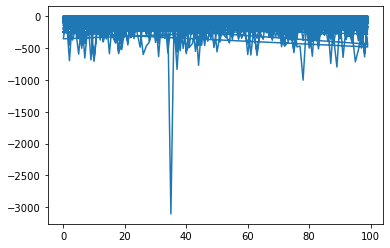

In [199]:
(wsb_cleaned['created_utc'].diff()).plot()

<AxesSubplot:>

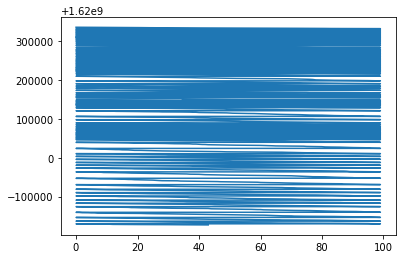

In [200]:
(wsb_cleaned['created_utc'].plot.line())

In [36]:
reddit.subreddit(subreddit).top(limit=num_samples)

AttributeError: 'ListingGenerator' object has no attribute 'name'